Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...

'build' took 1.605732 s


'compile' took 3.999611 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [4.63e-03, 3.56e-03, 7.57e-05, 2.12e+02]    [3.90e-03, 3.56e-03, 7.57e-05, 2.12e+02]    [9.99e-01]    
1000      [1.16e-01, 2.05e-03, 3.84e-02, 6.92e-01]    [8.87e-02, 2.05e-03, 3.84e-02, 6.92e-01]    [4.94e-02]    
2000      [6.86e-03, 2.55e-04, 2.45e-02, 3.44e-02]    [4.19e-03, 2.55e-04, 2.45e-02, 3.44e-02]    [2.91e-02]    
3000      [4.43e-03, 2.10e-04, 8.39e-02, 1.86e-02]    [2.12e-03, 2.10e-04, 8.39e-02, 1.86e-02]    [2.94e-02]    
4000      [2.09e-03, 2.12e-05, 8.74e-04, 6.36e-03]    [1.37e-03, 2.12e-05, 8.74e-04, 6.36e-03]    [2.72e-02]    
5000      [2.39e-03, 3.90e-05, 4.84e-02, 1.00e-02]    [9.69e-04, 3.90e-05, 4.84e-02, 1.00e-02]    [2.83e

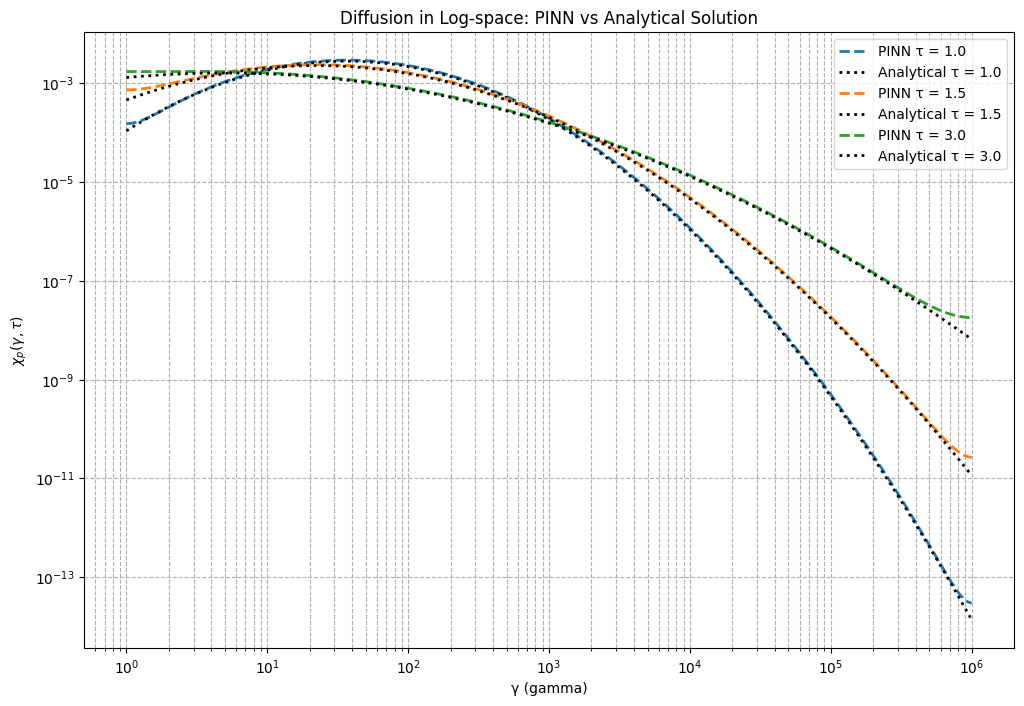

L1 error: 6.3003e-02


In [1]:
from deepxde.backend import tf
import deepxde as dde
import numpy as np
import tensorflow.random as tfr
import matplotlib.pyplot as plt

np.random.seed(1234)
tfr.set_seed(1234)

g_min = np.log(1)
g_max = np.log(1e6)
tau_min = 1.0
tau_max = 3.0
gamma0 = 100.0

def analytic_solution(g, tau, gamma0=100.0):
    gamma = np.exp(g)
    term1 = 1 / (gamma * np.sqrt(4 * np.pi * tau))
    log_term = np.log(gamma0 / gamma) + tau
    exponent = -(log_term ** 2) / (4 * tau)
    return term1 * np.exp(exponent)

# Transformed PDE for h = log(y)
def pde_log(x, h):
    dh_tau = dde.grad.jacobian(h, x, i=0, j=1)
    dh_g = dde.grad.jacobian(h, x, i=0, j=0)
    dh_g2 = dde.grad.hessian(h, x, i=0, j=0)
    return dh_tau - (dh_g2 + dh_g**2 + dh_g)

# Geometry
geom = dde.geometry.Interval(g_min, g_max)
timedomain = dde.geometry.TimeDomain(tau_min, tau_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# IC in h-space
def ic_function(x):
    return np.log(analytic_solution(x[:, 0:1], tau_min))

# Neumann BCs
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], g_min)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], g_max)

bc_left = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_left)
bc_right = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_right)
ic = dde.icbc.IC(geomtime, ic_function, lambda _, on_initial: on_initial)

# Data
data = dde.data.TimePDE(
    geomtime,
    pde_log,
    [bc_left, bc_right, ic],
    num_domain=8000,
    num_boundary=800,
    num_initial=800,
    solution=lambda x: np.log(analytic_solution(x[:, 0:1], x[:, 1:2])),
    num_test=1000,
)

# Network
net = dde.nn.FNN([2] + [64]*4 + [1], "tanh", "Glorot normal")

# Model
model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"],loss_weights=[1.0, 1.0, 1.0, 1.0])
losshistory, train_state = model.train(iterations=10000)

# Prediction
gamma_vals = np.logspace(0, 6, 200)
g_vals = np.log(gamma_vals)
tau_values = [1.0, 1.5, 3.0]

plt.figure(figsize=(12, 8))
for tau in tau_values:
    x_test = np.vstack((g_vals, np.full_like(g_vals, tau))).T
    h_pred = model.predict(x_test).flatten()
    y_pred = np.exp(h_pred)
    y_true = analytic_solution(g_vals, tau)

    plt.plot(gamma_vals, y_pred, '--', lw=2, label=f'PINN τ = {tau}')
    plt.plot(gamma_vals, y_true, 'k:', lw=2, label=f'Analytical τ = {tau}')

plt.xlabel("γ (gamma)")
plt.ylabel(r'$\chi_p(\gamma, \tau)$')
plt.xscale('log')
plt.yscale('log')
plt.title("Diffusion in Log-space: PINN vs Analytical Solution")
plt.legend()
plt.grid(True, which='both', ls='--')
plt.savefig("logspace_diffusion_pinn_vs_analytic.png")
plt.show()

# L1 Error
def calculate_l1_error(model, num_points=200):
    gamma_test = np.logspace(np.log10(1), np.log10(1e6), num_points)
    g_test = np.log(gamma_test)
    tau_test = np.linspace(tau_min, tau_max, num_points)
    g_grid, tau_grid = np.meshgrid(g_test, tau_test)

    x_test = np.vstack((g_grid.flatten(), tau_grid.flatten())).T
    h_pred = model.predict(x_test).flatten()
    y_pred = np.exp(h_pred)
    y_true = analytic_solution(x_test[:, 0], x_test[:, 1])

    l1_error = np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(y_true))
    return l1_error

l1_error = calculate_l1_error(model)
print(f"L1 error: {l1_error:.4e}")
